In [1]:
# project: p1
# submitter: xlu323@wisc.edu
# partner: none
# hours: 6

In [2]:
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt

In [3]:
#q1

def read_csv_to_tensor(file_name, mode):
    with open(file_name,encoding='utf-8') as f:
        train_file = pd.read_csv(f)
    f.close()
    
    DTH_CUM_CP = train_file.columns[-1]
    
    if mode == 'el':
        trian_file_to_torch = train_file.loc[:, train_file.columns != DTH_CUM_CP]
        torch_file = torch.tensor(trian_file_to_torch.values, dtype=torch.float64)
    if mode == 'ol':
        trian_file_to_torch = train_file.loc[:,train_file.columns == DTH_CUM_CP]
        torch_file = torch.tensor(trian_file_to_torch.values, dtype=torch.float64)

    return torch_file

trainX = read_csv_to_tensor('train.csv','el')
trainY = read_csv_to_tensor('train.csv','ol')
testX = read_csv_to_tensor('test.csv','el')
testY = read_csv_to_tensor('test.csv','ol')
coef = torch.tensor([
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040],
        [0.0040], # POS_50_59_CP
        [0.0300], # POS_60_69_CP
        [0.0300],
        [0.0300],
        [0.0300]
], dtype=testX.dtype)


if torch.cuda.is_available(): 
    print("on GPU")
    trainX = trainX.to("cuda")
    trainY = trainY.to("cuda")
    testX = testX.to("cuda")
    testY = testY.to("cuda")
    first_testX = testX[0]@coef
    print(first_testX.item())
else:
    first_testX = testX[0]@coef
    print(first_testX.item())
    


9.844


In [4]:
#q2
def r2_score(trueY, predictedY):
    trueY_mean = torch.mean(trueY)
    SStot = torch.sum((trueY-trueY_mean)**2)
    SSreg = torch.sum((trueY-predictedY)**2)
    
    improvement = SStot - SSreg
    r2_score = improvement/SStot
    
    return r2_score
predictedY = testX@coef
testY_r2_score = r2_score(testY, predictedY)
testY_r2_score

tensor(0.4110, dtype=torch.float64)

In [5]:
#q3

x = torch.tensor([0.0], requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.1)

for a in range(30):
    optimizer.zero_grad()
    y = x**2 - 8*x + 19
    y.backward()
    optimizer.step()
    print(x, y)


    
    

tensor([0.8000], requires_grad=True) tensor([19.], grad_fn=<AddBackward0>)
tensor([1.4400], requires_grad=True) tensor([13.2400], grad_fn=<AddBackward0>)
tensor([1.9520], requires_grad=True) tensor([9.5536], grad_fn=<AddBackward0>)
tensor([2.3616], requires_grad=True) tensor([7.1943], grad_fn=<AddBackward0>)
tensor([2.6893], requires_grad=True) tensor([5.6844], grad_fn=<AddBackward0>)
tensor([2.9514], requires_grad=True) tensor([4.7180], grad_fn=<AddBackward0>)
tensor([3.1611], requires_grad=True) tensor([4.0995], grad_fn=<AddBackward0>)
tensor([3.3289], requires_grad=True) tensor([3.7037], grad_fn=<AddBackward0>)
tensor([3.4631], requires_grad=True) tensor([3.4504], grad_fn=<AddBackward0>)
tensor([3.5705], requires_grad=True) tensor([3.2882], grad_fn=<AddBackward0>)
tensor([3.6564], requires_grad=True) tensor([3.1845], grad_fn=<AddBackward0>)
tensor([3.7251], requires_grad=True) tensor([3.1181], grad_fn=<AddBackward0>)
tensor([3.7801], requires_grad=True) tensor([3.0756], grad_fn=<Add

/tmp/ipykernel_149970/639546544.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX= torch.tensor(trainX, dtype=torch.float32)
/tmp/ipykernel_149970/639546544.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY= torch.tensor(trainY, dtype=torch.float32)


Loss: 27.11383056640625
R2 score: 0.5418499708175659
Time: 6.8926842212677


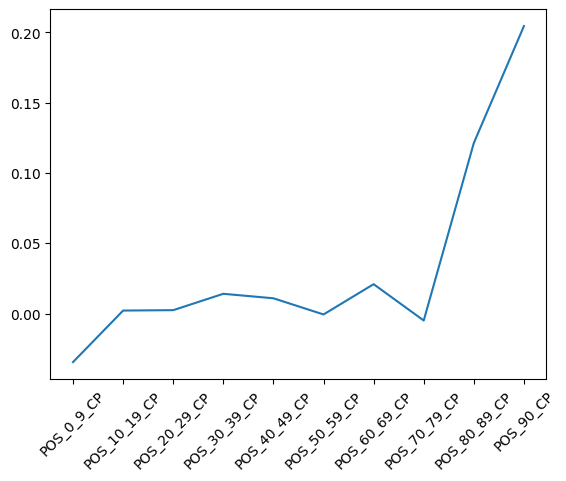

In [6]:
#q4
trainX= torch.tensor(trainX, dtype=torch.float32)
trainY= torch.tensor(trainY, dtype=torch.float32)

ds = torch.utils.data.TensorDataset(trainX,trainY)
dl = torch.utils.data.DataLoader(ds, shuffle=True, batch_size=32)

model = torch.nn.Linear(trainX.shape[-1], trainY.shape[-1])
optimizer = torch.optim.SGD([model.weight, model.bias], lr=0.000001)
loss_fn = torch.nn.MSELoss()

begin = time.time()
for epoch in range(400):
    # getting from the lecture
    for batchx, batchy in dl:
        predictedy = model(batchx)
        loss = loss_fn(batchy, predictedy)
        loss.backward()         # update weight.grad and bias.grad
        optimizer.step()        # update weight and bias based on the gradients
        optimizer.zero_grad()   # weight.grad = 0 and bias.grad = 0
end = time.time()    
all_time = end-begin
lostfn = loss_fn(trainY, model(trainX)).item()
r2score = r2_score(model(trainX), trainY).item()
print('Loss:', lostfn)
print('R2 score:',r2score)
print('Time:',all_time)

x_name = pd.read_csv('train.csv').columns.values.tolist()[0:-1]
y_weight = model.weight.tolist()[0]
plt.plot(x_name,y_weight)
plt.xticks(rotation = 45)
plt.show()